In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

In [ ]:
train_dir = '/content/drive/MyDrive/New_ISL/train'
test_dir = '/content/drive/MyDrive/New_ISL/valid'

In [ ]:
# ImageDataGenerator for training and testing
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.3,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    shear_range=0.3,  # Increased shear
    zoom_range=0.3,  # Increased zoom
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical',shuffle=False)

Found 900 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [ ]:
#######################

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical',shuffle=False)

Found 900 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [ ]:
# Visualize some sample images
def plot_sample_images(generator, class_indices):
    images, labels = next(generator)
    class_labels = list(class_indices.keys()) #for multiclass
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

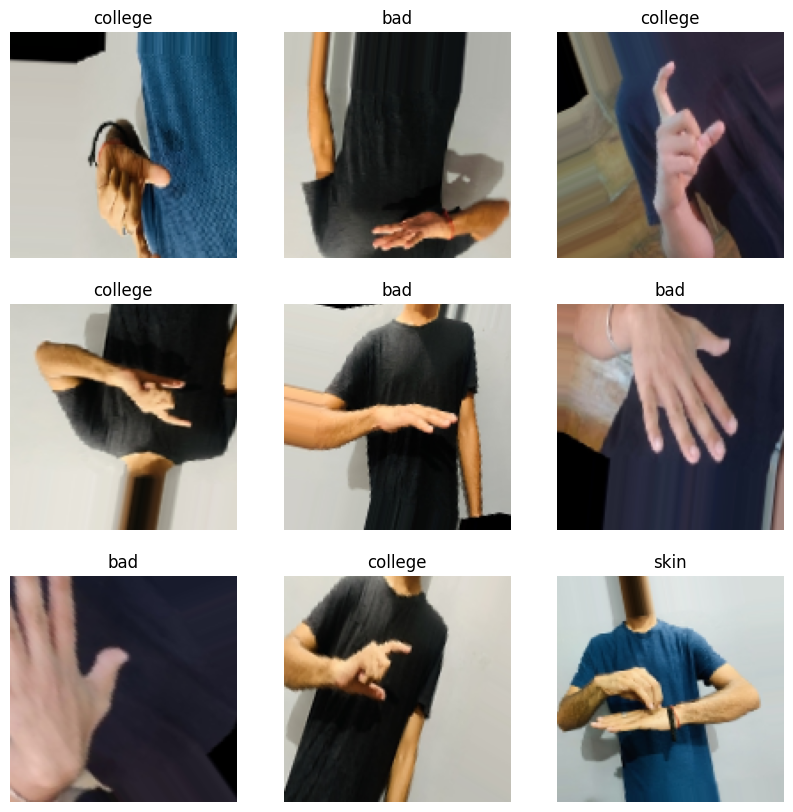

In [ ]:
import numpy as np
plot_sample_images(train_generator, train_generator.class_indices)

In [ ]:
#calculate and visualize class distribution
import numpy as np
class_counts = np.bincount(train_generator.classes)
print(f"Class Distribution: {class_counts}")

Class Distribution: [300 300 300]


In [ ]:
#calculate and visualize class distribution
import numpy as np
class_counts = np.bincount(test_generator.classes)
print(f"Class Distribution: {class_counts}")

Class Distribution: [150 150 150]


In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# CNN model with L2 regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)), #adding regulizers
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.metrics import AUC

# Compile with AUC
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import roc_auc_score, confusion_matrix
import time

In [ ]:
# Start timing
start_time = time.time()

In [ ]:
# Index to class mapping
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
import time
from sklearn.metrics import roc_auc_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.callbacks import Callback
import numpy as np

class CustomMetrics(Callback):
    def __init__(self, validation_data, class_indices):
        super(CustomMetrics, self).__init__()
        self.validation_data = validation_data
        self.class_indices = class_indices
        self.class_labels = list(class_indices.keys())

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        val_gen = self.validation_data
        y_true = []
        y_pred = []

        for batch in val_gen:
            x_batch, y_batch = batch
            preds = self.model.predict(x_batch)
            y_true.extend(np.argmax(y_batch, axis=1))
            y_pred.extend(np.argmax(preds, axis=1))
            if len(y_true) >= val_gen.samples:
                break

        y_true = np.array(y_true[:val_gen.samples])
        y_pred = np.array(y_pred[:val_gen.samples])

        # AUC (One-vs-Rest style)
        try:
            y_true_ovr = np.eye(len(self.class_labels))[y_true]
            y_pred_proba = self.model.predict(val_gen, verbose=0)
            auc_score = roc_auc_score(y_true_ovr, y_pred_proba, average='macro', multi_class='ovr')
        except:
            auc_score = -1

        # BLEU score (synthetic)
        smoothie = SmoothingFunction().method4
        bleu_scores = []
        for idx in range(len(y_true)):
            reference = [self.class_labels[y_true[idx]].split()]
            hypothesis = self.class_labels[y_pred[idx]].split()
            score = sentence_bleu(reference, hypothesis, smoothing_function=smoothie)
            bleu_scores.append(score)
        avg_bleu = np.mean(bleu_scores)

        # IoU (Intersection over Union)
        intersection = np.sum(y_true == y_pred)
        union = len(y_true)
        iou = intersection / union if union > 0 else 0

        # Computation time
        epoch_time = time.time() - self.epoch_start_time

        print(f"\n📊 Custom Metrics — Epoch {epoch + 1}")
        print(f"➡ AUC Score: {auc_score:.4f}")
        print(f"➡ BLEU Score: {avg_bleu:.4f}")
        print(f"➡ IoU Score: {iou:.4f}")
        print(f"⏱ Epoch Time: {epoch_time:.2f} seconds\n")


In [ ]:
# Callbacks
custom_metrics_cb = CustomMetrics(test_generator, idx_to_class, sentence_generator_fn)
time_cb = TimeHistory()

NameError: name 'sentence_generator_fn' is not defined

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    class_weight=class_weight_dict,
    #callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3423 - loss: 2.5521 - val_accuracy: 0.5424 - val_loss: 1.1018
Epoch 2/10
 1/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5625 - loss: 1.2083

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.5625 - loss: 1.2083 - val_accuracy: 0.5871 - val_loss: 1.0690
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5699 - loss: 1.0670 - val_accuracy: 0.5714 - val_loss: 0.9526
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.5312 - loss: 0.9858 - val_accuracy: 0.5536 - val_loss: 0.9746
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5246 - loss: 0.9898 - val_accuracy: 0.5804 - val_loss: 0.9218
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.4375 - loss: 1.2426 - val_accuracy: 0.6071 - val_loss: 0.8504
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6089 - loss: 0.8973 - val_accuracy: 0.6897 - val_loss: 0.7581
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.7812 - loss: 0.7290 - val_accuracy: 0.6116 - val_loss: 0.7934
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6548 - loss: 0.8277 - val_accuracy: 0.7634 - val_loss: 

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    class_weight=class_weight_dict,
    #callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6515 - loss: 0.7659 - val_accuracy: 0.6920 - val_loss: 0.8554
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.7500 - loss: 0.7469 - val_accuracy: 0.6496 - val_loss: 0.8097
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7089 - loss: 0.7037 - val_accuracy: 0.7254 - val_loss: 0.6777
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.7188 - loss: 0.7301 - val_accuracy: 0.7455 - val_loss: 0.6123
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7754 - loss: 0.6321 - val_accuracy: 0.7768 - val_loss: 0.5590
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.7812 - loss: 0.5774 - val_accuracy: 0.7500 - val_loss: 0.5684
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8165 - loss: 0.5151 - val_accuracy: 0.8080 - val_loss: 0.4644
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.8750 - loss: 0.5157 - val_accuracy: 0.7277 -

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    class_weight=class_weight_dict,
    #callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8438 - loss: 0.4995 - val_accuracy: 0.8482 - val_loss: 0.5397
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 1.0000 - loss: 0.2832 - val_accuracy: 0.9330 - val_loss: 0.4135
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8775 - loss: 0.4365 - val_accuracy: 0.9420 - val_loss: 0.3545
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.9062 - loss: 0.3732 - val_accuracy: 0.9464 - val_loss: 0.3424
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8631 - loss: 0.4286 - val_accuracy: 0.7835 - val_loss: 0.8022
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.8125 - loss: 0.4972 - val_accuracy: 0.7165 - val_loss: 0.9948
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8309 - loss: 0.4979 - val_accuracy: 0.8527 - val_loss: 0.4270
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.9375 - loss: 0.2730 - val_accuracy: 0.8259 

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    class_weight=class_weight_dict,
    #callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9342 - loss: 0.3200 - val_accuracy: 0.8304 - val_loss: 0.5536
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9375 - loss: 0.2657 - val_accuracy: 0.8125 - val_loss: 0.5953
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8857 - loss: 0.4118 - val_accuracy: 0.6272 - val_loss: 0.8558
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6250 - loss: 0.9075 - val_accuracy: 0.5312 - val_loss: 0.9176
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7738 - loss: 0.6983 - val_accuracy: 0.8728 - val_loss: 0.3736
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.7188 - loss: 0.7119 - val_accuracy: 0.7879 - val_loss: 0.4354
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8815 - loss: 0.4754 - val_accuracy: 0.8772 - val_loss: 0.4144
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 1.0000 - loss: 0.2617 - val_accuracy: 0.9330 - 

In [ ]:
# End timing
end_time = time.time()
print(f"\n🕒 Training Time: {end_time - start_time:.2f} seconds")


🕒 Training Time: 1832.03 seconds


In [ ]:
# Step 6: Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - accuracy: 0.9712 - loss: 0.2839
Test Accuracy: 0.948888897895813


In [ ]:
# Predict on the test data
y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step


In [ ]:
# Classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_class, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       150
     college       1.00      0.85      0.92       150
        skin       0.87      1.00      0.93       150

    accuracy                           0.95       450
   macro avg       0.96      0.95      0.95       450
weighted avg       0.96      0.95      0.95       450



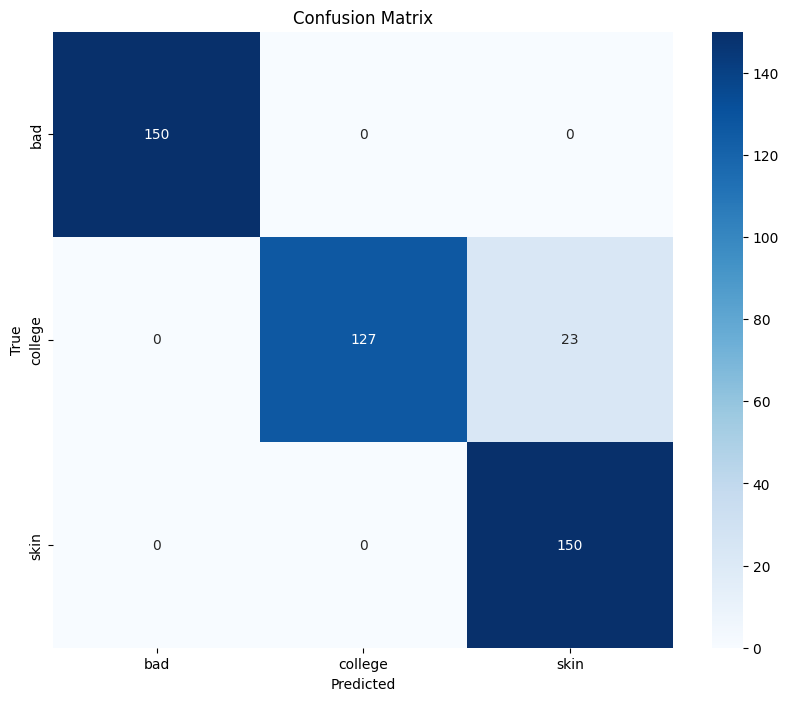

In [ ]:
# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class, average='weighted')  # Weighted for multiclass
recall = recall_score(y_true, y_pred_class, average='weighted')
f1 = f1_score(y_true, y_pred_class, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9489
Precision: 0.9557
Recall: 0.9489
F1 Score: 0.9486


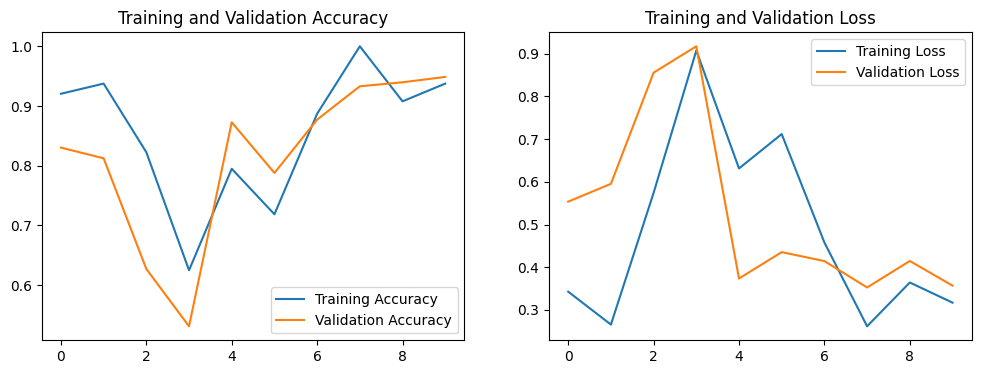

In [ ]:
# Plot training and validation accuracy and loss
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_performance(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


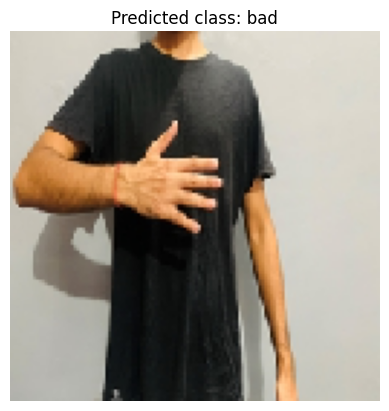

bad_740_User5_740.jpg: Predicted class is bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


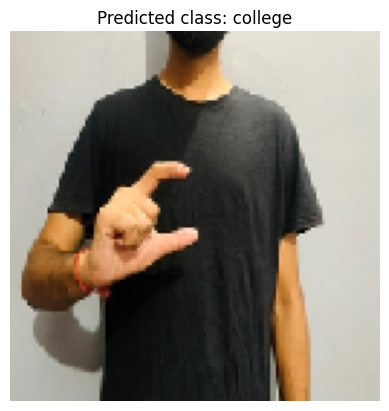

college_452_User4_452.jpg: Predicted class is college
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


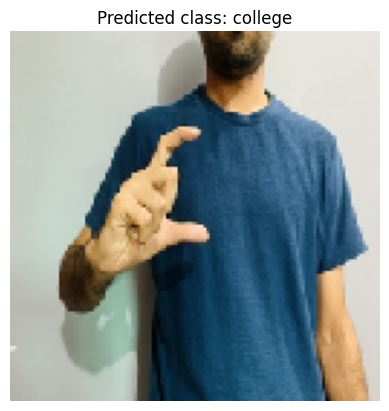

college_770_User6_770.jpg: Predicted class is college
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


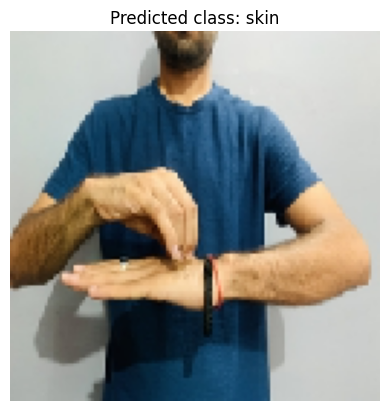

skin892_User6_892.jpg: Predicted class is skin


In [ ]:
# Predict and display results for user-uploaded images
from tensorflow.keras.preprocessing import image

def predict_image(image_path, model, class_indices, display_image=False):
    """
    Predict the class for a given image.

    Args:
        image_path (str): Path to the image file.
        model: Pretrained TensorFlow/Keras model.
        class_indices: Dictionary of class indices.
        display_image (bool): Whether to display the image with the prediction.

    Returns:
        str: Predicted class.
    """
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(prediction)]

    if display_image:
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class}')
        plt.axis('off')
        plt.show()

    return predicted_class

# Example predictions
test_images = ['bad_740_User5_740.jpg', 'college_452_User4_452.jpg', 'college_770_User6_770.jpg', 'skin892_User6_892.jpg']
for img_path in test_images:
    result = predict_image(img_path, model, train_generator.class_indices, display_image=True)
    print(f'{img_path}: Predicted class is {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


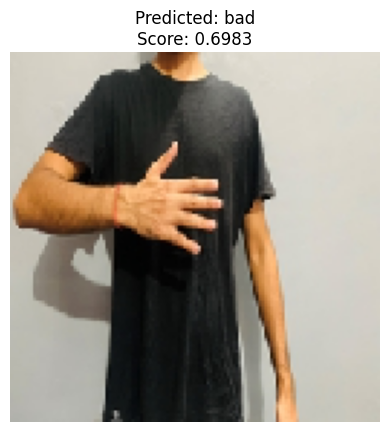

bad_740_User5_740.jpg:
  ➤ Predicted class: bad
  ➤ Confidence: 0.6983
  ➤ All class scores: {'bad': 0.6983, 'college': 0.2688, 'skin': 0.0329}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


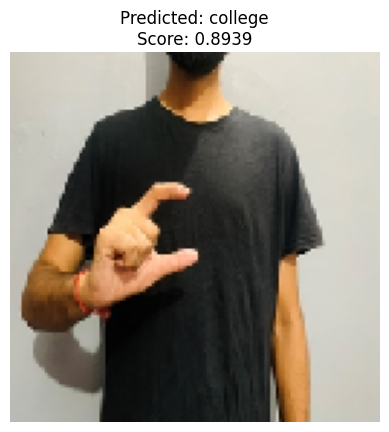

college_452_User4_452.jpg:
  ➤ Predicted class: college
  ➤ Confidence: 0.8939
  ➤ All class scores: {'bad': 0.092, 'college': 0.8939, 'skin': 0.0141}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


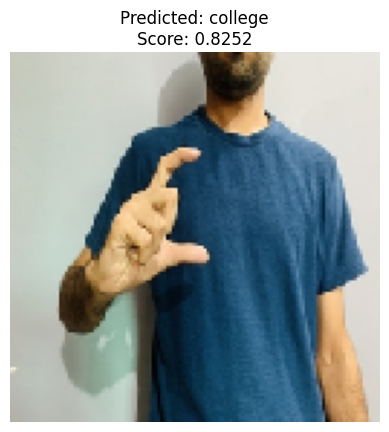

college_770_User6_770.jpg:
  ➤ Predicted class: college
  ➤ Confidence: 0.8252
  ➤ All class scores: {'bad': 0.0, 'college': 0.8252, 'skin': 0.1748}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


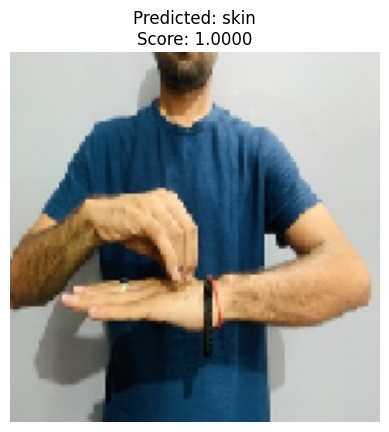

skin892_User6_892.jpg:
  ➤ Predicted class: skin
  ➤ Confidence: 1.0000
  ➤ All class scores: {'bad': 0.0, 'college': 0.0, 'skin': 1.0}



In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, class_indices, display_image=False):
    """
    Predict the class for a given image and display prediction scores.

    Args:
        image_path (str): Path to the image file.
        model: Pretrained TensorFlow/Keras model.
        class_indices: Dictionary of class indices.
        display_image (bool): Whether to display the image with the prediction.

    Returns:
        Tuple[str, float, dict]: Predicted class, its probability, all class scores.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    predictions = model.predict(img_array)[0]  # Take first (and only) prediction
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    prediction_score = predictions[predicted_index]

    # Map class scores to their class names
    class_scores = {class_name: float(f"{predictions[idx]:.4f}") for class_name, idx in class_indices.items()}

    if display_image:
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class}\nScore: {prediction_score:.4f}')
        plt.axis('off')
        plt.show()

    return predicted_class, prediction_score, class_scores

test_images = [
    'bad_740_User5_740.jpg',
    'college_452_User4_452.jpg',
    'college_770_User6_770.jpg',
    'skin892_User6_892.jpg'
]

for img_path in test_images:
    predicted_class, score, all_scores = predict_image(
        img_path,
        model,
        train_generator.class_indices,
        display_image=True
    )
    print(f"{img_path}:")
    print(f"  ➤ Predicted class: {predicted_class}")
    print(f"  ➤ Confidence: {score:.4f}")
    print(f"  ➤ All class scores: {all_scores}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


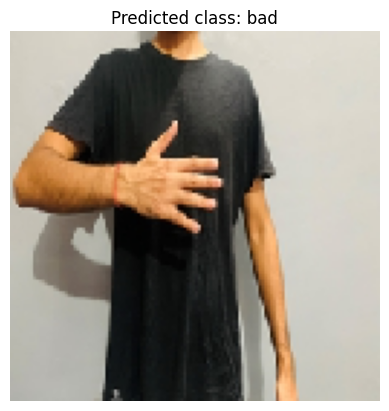

bad_740_User5_740.jpg: Predicted class is bad


In [ ]:
# Predict and display results for user-uploaded images
from tensorflow.keras.preprocessing import image

def predict_image(image_path, model, class_indices, display_image=False):
    """
    Predict the class for a given image.

    Args:
        image_path (str): Path to the image file.
        model: Pretrained TensorFlow/Keras model.
        class_indices: Dictionary of class indices.
        display_image (bool): Whether to display the image with the prediction.

    Returns:
        str: Predicted class.
    """
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(prediction)]

    if display_image:
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class}')
        plt.axis('off')
        plt.show()

    return predicted_class

# Example predictions
test_images = ['bad_740_User5_740.jpg']
for img_path in test_images:
    result = predict_image(img_path, model, train_generator.class_indices, display_image=True)
    print(f'{img_path}: Predicted class is {result}')

In [ ]:
# AUC Score
try:
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))
    auc_score = roc_auc_score(y_true_bin, y_pred, multi_class='ovo')
    print(f"AUC Score: {auc_score:.4f}")
except Exception as e:
    print("AUC Calculation Error:", str(e))

AUC Score: 0.9862


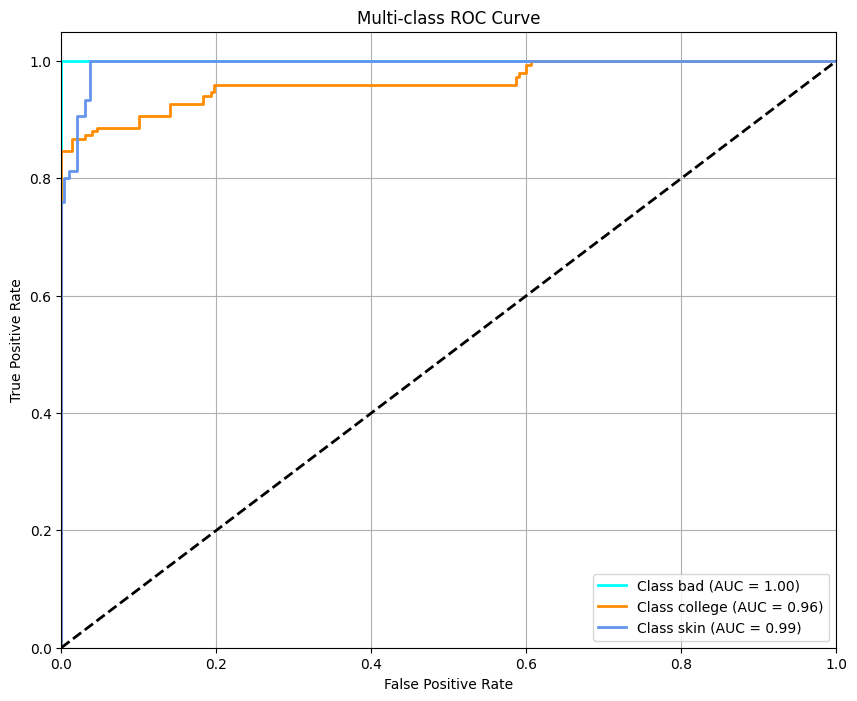

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf

try:
    # One-hot encode true labels
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))

    # Dictionary to hold per-class AUCs
    class_auc_scores = {}

    print("📊 AUC Score per Class:")
    for i, class_name in enumerate(class_labels):
        auc = roc_auc_score(y_true_bin[:, i], y_pred[:, i])
        class_auc_scores[class_name] = auc
        print(f"  {class_name}: {auc:.4f}")

    # Optionally, compute average AUC
    avg_auc = np.mean(list(class_auc_scores.values()))
    print(f"\n🔁 Average AUC Score: {avg_auc:.4f}")

except Exception as e:
    print("AUC Calculation Error:", str(e))


📊 AUC Score per Class:
  bad: 1.0000
  college: 0.9640
  skin: 0.9946

🔁 Average AUC Score: 0.9862


In [ ]:
# BLEU Score
smoothie = SmoothingFunction().method1
bleu_scores = []
for true_idx, pred_idx in zip(y_true, y_pred_class):
    reference = [class_labels[true_idx].split()]
    candidate = class_labels[pred_idx].split()
    bleu = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu_scores.append(bleu)

avg_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {avg_bleu:.4f}")


Average BLEU Score: 0.9489


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
from collections import defaultdict

# Smoothing function
smoothie = SmoothingFunction().method1

# Dictionary to collect BLEU scores per class
class_bleu_scores = defaultdict(list)

# Loop over all samples
for true_idx, pred_idx in zip(y_true, y_pred_class):
    true_label = class_labels[true_idx]
    pred_label = class_labels[pred_idx]

    reference = [true_label.split()]
    candidate = pred_label.split()

    bleu = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    class_bleu_scores[true_label].append(bleu)

# Compute and print average BLEU per class
print("📊 BLEU Score per Class:")
for class_name in class_labels:
    scores = class_bleu_scores[class_name]
    if scores:
        avg_score = np.mean(scores)
        print(f"  {class_name}: {avg_score:.4f}")
    else:
        print(f"  {class_name}: No samples")


📊 BLEU Score per Class:
  bad: 1.0000
  college: 0.8467
  skin: 1.0000


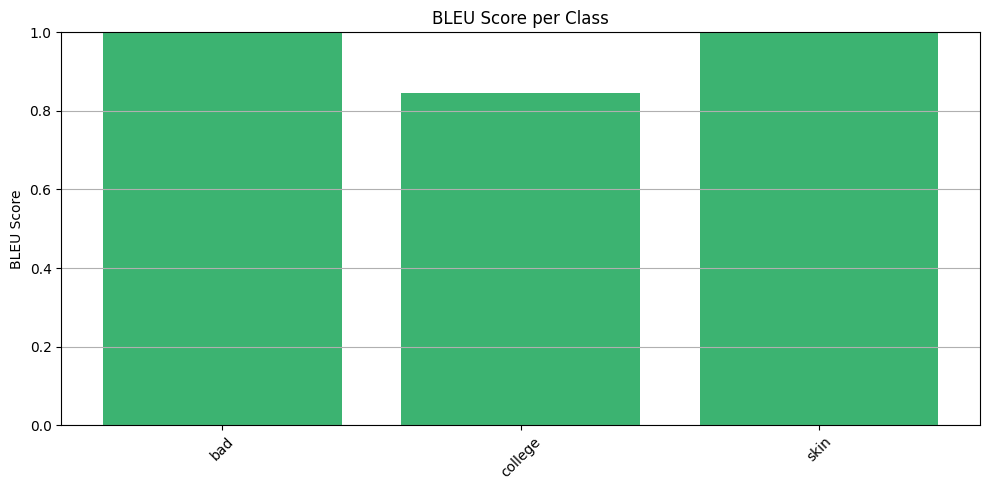

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
class_names = []
avg_scores = []

for class_name in class_labels:
    scores = class_bleu_scores[class_name]
    if scores:
        class_names.append(class_name)
        avg_scores.append(np.mean(scores))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(class_names, avg_scores, color='mediumseagreen')
plt.title("BLEU Score per Class")
plt.ylabel("BLEU Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# IoU
intersection = np.diag(cm)
ground_truth_set = cm.sum(axis=1)
predicted_set = cm.sum(axis=0)
union = ground_truth_set + predicted_set - intersection
iou_per_class = intersection / union
mean_iou = np.mean(iou_per_class)

for i, label in enumerate(class_labels):
    print(f"IoU for class '{label}': {iou_per_class[i]:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

IoU for class 'bad': 1.0000
IoU for class 'college': 0.8467
IoU for class 'skin': 0.8671
Mean IoU: 0.9046


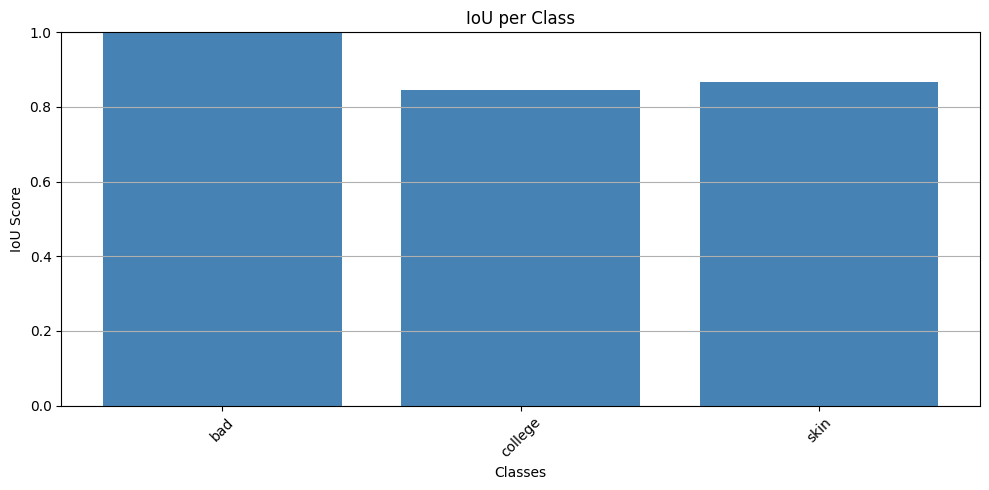

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(class_labels, iou_per_class, color='steelblue')
plt.ylim(0, 1)
plt.xlabel('Classes')
plt.ylabel('IoU Score')
plt.title('IoU per Class')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
!pip install gTTS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [ ]:
import IPython.display as ipd


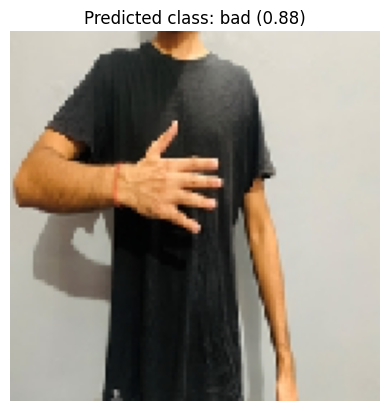


🖼️ bad_740_User5_740.jpg: Predicted class is "bad" with confidence 0.88


HTML(value='<b>Generated Sentence:</b><br>"They notice that this is a bad."')

Button(button_style='success', description='✅ Accept', style=ButtonStyle())

Button(button_style='warning', description='✏️ Edit', style=ButtonStyle())

Output()

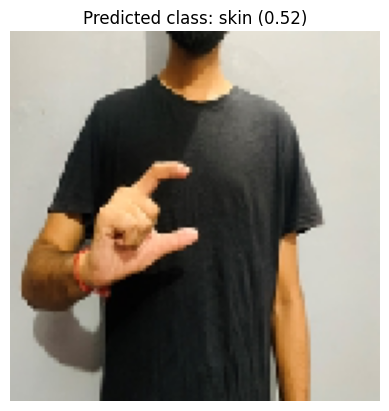


🖼️ college_452_User4_452.jpg: Predicted class is "skin" with confidence 0.52


HTML(value='<b>Generated Sentence:</b><br>"This is a skin, but it makes sense."')

Button(button_style='success', description='✅ Accept', style=ButtonStyle())

Button(button_style='warning', description='✏️ Edit', style=ButtonStyle())

Output()

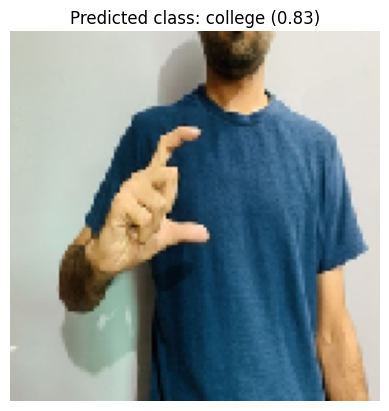


🖼️ college_770_User6_770.jpg: Predicted class is "college" with confidence 0.83


HTML(value='<b>Generated Sentence:</b><br>"We see something about college."')

Button(button_style='success', description='✅ Accept', style=ButtonStyle())

Button(button_style='warning', description='✏️ Edit', style=ButtonStyle())

Output()

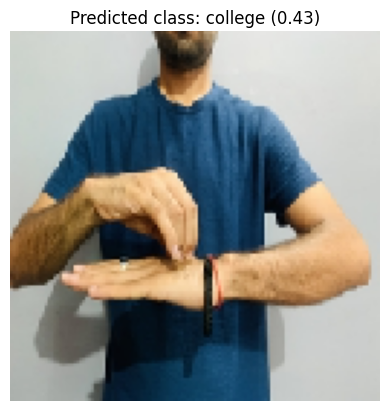


🖼️ skin892_User6_892.jpg: Predicted class is "college" with confidence 0.43


HTML(value='<b>Generated Sentence:</b><br>"This is the college, and it makes sense."')

Button(button_style='success', description='✅ Accept', style=ButtonStyle())

Button(button_style='warning', description='✏️ Edit', style=ButtonStyle())

Output()


✅ Final output: They notice that this is a bad. This is a skin, but it does not make sense because a wrong class is detected. We see something about college. This is the college, and it do not make sense because wrong class .
🔊 Playing the final translated audio...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from gtts import gTTS
import IPython.display as ipd
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

# Dummy model and class_indices to simulate prediction (replace with your own)
class DummyModel:
    def predict(self, img_array):
        return np.array([[random.random() for _ in range(3)]])
model = DummyModel()
class_indices = {'bad': 0, 'college': 1, 'skin': 2}

# Test image list
test_images = [
    'bad_740_User5_740.jpg',
    'college_452_User4_452.jpg',
    'college_770_User6_770.jpg',
    'skin892_User6_892.jpg'
]

# Store valid sentences globally to generate audio at end
valid_sentences = []

# POS components
pronouns = ["I", "We", "They", "It"]
verbs = ["see", "think", "feel", "believe", "notice"]
articles = ["a", "the"]
prepositions = ["like", "about", "of", "with"]
conjunctions = ["and", "but", "so", "because"]
adverbs = ["probably", "definitely", "clearly", "usually"]

# Build sentence using POS structure
def create_sentence(word):
    pronoun = random.choice(pronouns)
    verb = random.choice(verbs)
    article = random.choice(articles)
    preposition = random.choice(prepositions)
    adverb = random.choice(adverbs)
    conjunction = random.choice(conjunctions)

    sentence_structures = [
        f"{pronoun} {verb} {article} {word}.",
        f"{pronoun} {verb} {preposition} {word}.",
        f"{pronoun} {verb} that this is {article} {word}.",
        f"{pronoun} {verb} it is {adverb} {word}.",
        f"This is {article} {word}, {conjunction} it makes sense.",
        f"{pronoun} {verb} something {preposition} {word}.",
    ]
    return random.choice(sentence_structures)

# Predict class from image
def predict_image(image_path, model, class_indices, display_image=False):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(prediction)]
    prediction_score = np.max(prediction)

    if display_image:
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class} ({prediction_score:.2f})')
        plt.axis('off')
        plt.show()

    return predicted_class, prediction_score

def get_feedback_ui(sentence, callback):
    btn_yes = widgets.Button(description="✅ Accept", button_style='success')
    btn_no = widgets.Button(description="✏️ Edit", button_style='warning')
    out = widgets.Output()
    edit_box = widgets.Textarea(
        value=sentence,
        placeholder='Edit the sentence here...',
        description='Your Edit:',
        layout=widgets.Layout(width='100%', height='60px')
    )
    submit_btn = widgets.Button(description="Submit Edit", button_style='primary')

    # Text-to-speech playback for sentence
    tts = gTTS(text=sentence, lang='en')
    temp_audio = "temp_sentence.mp3"
    tts.save(temp_audio)
    audio_player = ipd.Audio(temp_audio)

    def on_yes_clicked(b):
        with out:
            clear_output()
            print("✅ Sentence accepted.")
        callback('yes')

    def on_no_clicked(b):
        with out:
            clear_output()
            display(edit_box, submit_btn)

    def on_submit_edit(b):
        new_sentence = edit_box.value.strip()
        if new_sentence:
            valid_sentences.append(new_sentence)
            with out:
                clear_output()
                print(f"✏️ Sentence updated and accepted: \"{new_sentence}\"")
            callback('edited')
        else:
            with out:
                print("⚠️ Please enter a valid sentence before submitting.")

    btn_yes.on_click(on_yes_clicked)
    btn_no.on_click(on_no_clicked)
    submit_btn.on_click(on_submit_edit)

    display(widgets.HTML(f"<b>Generated Sentence:</b><br>\"{sentence}\""), audio_player, btn_yes, btn_no, out)


# Main loop — interactive
def process_images(index=0):
    if index >= len(test_images):
        # All done: convert accepted sentences to audio
        if valid_sentences:
            final_output = ' '.join(valid_sentences)
            print("\n✅ Final output:", final_output)
            tts = gTTS(text=final_output, lang='en')
            audio_path = "translated_output.mp3"
            tts.save(audio_path)
            print("🔊 Playing the final translated audio...")
            ipd.display(ipd.Audio(audio_path))
        else:
            print("\n⚠️ No valid sentences to convert to audio.")
        return

    img_path = test_images[index]
    label, score = predict_image(img_path, model, class_indices, display_image=True)
    print(f"\n🖼️ {img_path}: Predicted class is \"{label}\" with confidence {score:.2f}")
    sentence = create_sentence(label)

    def feedback_result(result):
        if result == 'yes':
            valid_sentences.append(sentence)
        # Move to next image
        process_images(index + 1)

    get_feedback_ui(sentence, feedback_result)

# Start the interactive loop
process_images()


In [ ]:
# Import necessary libraries
import os
import shutil
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Define the save path for the model
save_path = '/content/drive/MyDrive/New_ISL_CNN_93_output_fine.h5'

# Check if the save path is a directory
if os.path.isdir(save_path):
    print(f"Error: {save_path} is a directory. Removing it...")
    shutil.rmtree(save_path)  # Remove the directory

# Ensure the parent directory exists
os.makedirs('/content/drive/MyDrive', exist_ok=True)

# Save the model
try:
    model.save(save_path)
    print(f"Model successfully saved to {save_path}")
except Exception as e:
    print(f"Error occurred while saving the model: {e}")

Model successfully saved to /content/drive/MyDrive/New_ISL_CNN_93_output_fine.h5


In [ ]:
words = ["college", "bad", "skin"]

sentence_templates = [
    "The {word1} is {word2}.",
    "In {word1}, the {word3} got {word2}.",
    "{word3} is {word2}."
]

for template in sentence_templates:
    print(template.format(word1="college", word2="bad", word3="skin"))


The college is bad.
In college, the skin got bad.
skin is bad.


In [ ]:
import itertools

# CNN-Predicted Words
words = ["college", "bad", "skin"]

# Logical Sentence Templates
sentence_templates = [
    "The {word1} is {word2}.",
    "In {word1}, the {word3} got {word2}.",
    "{word3} is {word2}.",
    "The {word3} of {word1} is {word2}.",
    "{word1} makes {word3} {word2}."
]

# Generate All Possible Logical Sentences
sentences = []
for template in sentence_templates:
    for combo in itertools.permutations(words, 3):  # Generate all word orders
        sentence = template.format(word1=combo[0], word2=combo[1], word3=combo[2])
        sentences.append(sentence)

# Print Sample Sentences
for i, sent in enumerate(sentences[:10]):  # Show first 10 sentences
    print(f"{i+1}. {sent}")


1. The college is bad.
2. The college is skin.
3. The bad is college.
4. The bad is skin.
5. The skin is college.
6. The skin is bad.
7. In college, the skin got bad.
8. In college, the bad got skin.
9. In bad, the skin got college.
10. In bad, the college got skin.


In [ ]:
import random

# Define possible sentence structures
sentence_templates = [
    "The {noun1} is {adj}.",
    "In {noun1}, the {noun2} got {adj}.",
    "{noun2} became {adj} at {noun1}.",
    "The {noun2} of {noun1} is {adj}.",
    "{noun1} had {adj} {noun2}.",
    "{noun2} is not {adj}, but {noun1} is.",
    "Because of {noun1}, the {noun2} became {adj}.",
    "Studying at {noun1} made my {noun2} {adj}."
]

# Define words with their types
nouns = ["college", "skin"]
adjectives = ["bad"]

# Generate all possible sentences
sentences = []
for template in sentence_templates:
    for noun1 in nouns:
        for noun2 in nouns:
            if noun1 != noun2:  # Ensure at least two different words
                for adj in adjectives:
                    sentence = template.format(noun1=noun1, noun2=noun2, adj=adj)
                    sentences.append(sentence)

# Randomly shuffle and display a few generated sentences
random.shuffle(sentences)
for i, sentence in enumerate(sentences[:10]):  # Show 10 examples
    print(f"{i+1}. {sentence}")


1. Because of college, the skin became bad.
2. Studying at skin made my college bad.
3. The college of skin is bad.
4. Because of skin, the college became bad.
5. The skin is bad.
6. The skin of college is bad.
7. In skin, the college got bad.
8. skin became bad at college.
9. college is not bad, but skin is.
10. In college, the skin got bad.


In [ ]:
import random

# Define possible sentence structures
sentence_templates = [
    "The {noun1} is {adj}.",
    "In {noun1}, the {noun2} got {adj}.",
    "{noun2} became {adj} at {noun1}.",
    "The {noun2} of {noun1} is {adj}.",
    "{noun1} had {adj} {noun2}.",
    "{noun2} is not {adj}, but {noun1} is.",
    "Because of {noun1}, the {noun2} became {adj}.",
    "Studying at {noun1} made my {noun2} {adj}."
]

# Define words with their types
nouns = ["college", "skin"]
adjectives = ["bad"]

# Generate all possible sentences
sentences = []
for template in sentence_templates:
    for noun1 in nouns:
        for noun2 in nouns:
            if noun1 != noun2:  # Ensure at least two different words
                for adj in adjectives:
                    sentence = template.format(noun1=noun1, noun2=noun2, adj=adj)
                    sentences.append(sentence)

# Shuffle sentences
random.shuffle(sentences)

# Store approved sentences
approved_sentences = []

# Ask for feedback
for i, sentence in enumerate(sentences[:10]):  # Show 10 examples
    print(f"\nSentence {i+1}: {sentence}")
    feedback = input("Do you want to keep this sentence? (yes/no): ").strip().lower()
    if feedback == "yes":
        approved_sentences.append(sentence)

# Display final selected sentences
print("\n✅ Approved Sentences:")
for sentence in approved_sentences:
    print(f"- {sentence}")

print("\n🎉 Sentence selection complete!")



Sentence 1: college is not bad, but skin is.
Do you want to keep this sentence? (yes/no): yes

Sentence 2: Because of skin, the college became bad.
Do you want to keep this sentence? (yes/no): no

Sentence 3: college became bad at skin.
Do you want to keep this sentence? (yes/no): no

Sentence 4: skin had bad college.
Do you want to keep this sentence? (yes/no): no

Sentence 5: college had bad skin.
Do you want to keep this sentence? (yes/no): no

Sentence 6: The skin is bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 7: In college, the skin got bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 8: The college is bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 9: Because of college, the skin became bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 10: skin is not bad, but college is.
Do you want to keep this sentence? (yes/no): yes

✅ Approved Sentences:
- college is not bad, but skin is.
- The skin is bad.
- In college, the s

In [ ]:
!pip install gtts



In [ ]:
import random
from gtts import gTTS
import os

# Define possible sentence structures
sentence_templates = [
    "The {noun1} is {adj}.",
    "In {noun1}, the {noun2} got {adj}.",
    "{noun2} became {adj} at {noun1}.",
    "The {noun2} of {noun1} is {adj}.",
    "{noun1} had {adj} {noun2}.",
    "{noun2} is not {adj}, but {noun1} is.",
    "Because of {noun1}, the {noun2} became {adj}.",
    "Studying at {noun1} made my {noun2} {adj}."
]

# Define words with their types
nouns = ["college", "skin"]
adjectives = ["bad"]

# Generate all possible sentences
sentences = []
for template in sentence_templates:
    for noun1 in nouns:
        for noun2 in nouns:
            if noun1 != noun2:  # Ensure at least two different words
                for adj in adjectives:
                    sentence = template.format(noun1=noun1, noun2=noun2, adj=adj)
                    sentences.append(sentence)

# Shuffle sentences
random.shuffle(sentences)

# Store approved sentences
approved_sentences = []

# Ask for feedback
for i, sentence in enumerate(sentences[:5]):  # Show 5 examples
    print(f"\nSentence {i+1}: {sentence}")
    feedback = input("Do you want to keep this sentence? (yes/no): ").strip().lower()
    if feedback == "yes":
        approved_sentences.append(sentence)

# Convert approved sentences to speech
if approved_sentences:
    print("\n🎙 Converting sentences to speech...")

    for i, sentence in enumerate(approved_sentences):
        print(f"🔊 Saying: {sentence}")

        # Save as MP3 using gTTS
        tts = gTTS(sentence, lang="en")
        filename = f"sentence_{i+1}.mp3"
        tts.save(filename)
        print(f"📂 Saved: {filename}")

        # Play the audio
        if os.name == "nt":  # Windows
            os.system(f"start {filename}")
        elif os.name == "posix":  # macOS & Linux
            os.system(f"mpg321 {filename} || afplay {filename} || cvlc --play-and-exit {filename}")

    print("\n✅ All sentences converted to speech!")
else:
    print("\n⚠ No sentences were selected for speech conversion.")



Sentence 1: skin became bad at college.
Do you want to keep this sentence? (yes/no): yes

Sentence 2: In college, the skin got bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 3: The skin is bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 4: Because of college, the skin became bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 5: skin had bad college.
Do you want to keep this sentence? (yes/no): no

🎙 Converting sentences to speech...
🔊 Saying: skin became bad at college.
📂 Saved: sentence_1.mp3
🔊 Saying: In college, the skin got bad.
📂 Saved: sentence_2.mp3
🔊 Saying: The skin is bad.
📂 Saved: sentence_3.mp3
🔊 Saying: Because of college, the skin became bad.
📂 Saved: sentence_4.mp3

✅ All sentences converted to speech!


In [ ]:
!pip install gtts pygame


In [ ]:
!pip install gtts pydub simpleaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-linux_x86_64.whl size=2054423 sha256=a5dff63bf2a05d1547502772086b709d88814e2b1419000bf11880f02f380f3e
  Stored in directory: /root/.cache/pip/wheels/44/74/11/9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio


In [ ]:
import random
import os
from gtts import gTTS
from IPython.display import display, Audio
from google.colab import files

# Define possible sentence structures
sentence_templates = [
    "The {noun1} is {adj}.",
    "In {noun1}, the {noun2} got {adj}.",
    "{noun2} became {adj} at {noun1}.",
    "The {noun2} of {noun1} is {adj}.",
    "{noun1} had {adj} {noun2}.",
    "{noun2} is not {adj}, but {noun1} is.",
    "Because of {noun1}, the {noun2} became {adj}.",
    "Studying at {noun1} made my {noun2} {adj}."
]

# Define words with their types
nouns = ["college", "skin", ""]
adjectives = ["bad"]

# Generate all possible sentences
sentences = []
for template in sentence_templates:
    for noun1 in nouns:
        for noun2 in nouns:
            if noun1 != noun2:  # Ensure at least two different words
                for adj in adjectives:
                    sentence = template.format(noun1=noun1, noun2=noun2, adj=adj)
                    sentences.append(sentence)

# Shuffle sentences
random.shuffle(sentences)

# Store approved sentences
approved_sentences = []

# Ask for feedback
for i, sentence in enumerate(sentences[:10]):  # Show 10 examples
    print(f"\nSentence {i+1}: {sentence}")
    feedback = input("Do you want to keep this sentence? (yes/no): ").strip().lower()
    if feedback == "yes":
        approved_sentences.append(sentence)

# Display final selected sentences
print("\n✅ Approved Sentences:")
for sentence in approved_sentences:
    print(f"- {sentence}")

# Convert approved sentences to speech and generate MP3
if approved_sentences:
    print("\n🎙 Converting sentences to speech...")

    final_text = " ".join(approved_sentences)  # Combine sentences into a paragraph
    tts = gTTS(final_text, lang="en")
    filename = "approved_sentences.mp3"
    tts.save(filename)

    # Provide an option to download the file
    print("\n📥 Click the link below to download the speech file:")
    files.download(filename)

    # Play the audio directly in the notebook (optional)
    display(Audio(filename))
else:
    print("\n⚠ No sentences were selected for speech conversion.")



Sentence 1: In college, the skin got bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 2: college became bad at skin.
Do you want to keep this sentence? (yes/no): no

Sentence 3: skin is not bad, but college is.
Do you want to keep this sentence? (yes/no): yes

Sentence 4: The college of skin is bad.
Do you want to keep this sentence? (yes/no): no

Sentence 5: Because of college, the skin became bad.
Do you want to keep this sentence? (yes/no): yes

Sentence 6: skin became bad at college.
Do you want to keep this sentence? (yes/no): yes

Sentence 7: Studying at skin made my college bad.
Do you want to keep this sentence? (yes/no): no

Sentence 8: In skin, the college got bad.
Do you want to keep this sentence? (yes/no): no

Sentence 9: The skin of college is bad.
Do you want to keep this sentence? (yes/no): no

Sentence 10: college had bad skin.
Do you want to keep this sentence? (yes/no): no

✅ Approved Sentences:
- In college, the skin got bad.
- skin is not bad, but c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>